# Test using /lib package

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import lib

In [2]:
!ls logs/fixtime/

SGD             time_limit1800s


In [3]:
logdir = "logs/fixtime/time_limit1800s"
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

182

In [4]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df_epochtime.loc[ind] = [batch,learn,run,epoch,time,loss]
                ind += 1
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1

    return (df_epochtime, df_validation)

In [5]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return (df_epochtime, df_validation)
    return (df_epochtime, df_validation)

In [6]:
print logdir
df_epochtime,df_validation = readLogs(logdir,maxfiles=4)
print df_validation.shape, df_epochtime.shape

logs/fixtime/time_limit1800s
(4, 9) (587, 6)


In [7]:
df_validation

,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12.0,0.0001,0.0,0.212399,0.122199,0.079269,0.053763,0.239460,0.141409
1,12.0,0.0001,1.0,0.187402,0.112553,0.073595,0.050095,0.228863,0.122010
2,12.0,0.0005,0.0,0.509377,0.362138,0.265413,0.191779,0.406360,0.240103
3,12.0,0.0005,1.0,0.539671,0.395964,0.296946,0.223133,0.438080,0.282516


In [8]:
df_test = df_validation.copy()
df_test["ind"] = df_test["lr"]+df_test["run"]
df_test.drop(["batch","lr","run"],axis=1,inplace=True)
df_test.set_index(["ind"],inplace=True)
df_test

,bleu1,bleu2,bleu3,bleu4,rouge,cider
ind,,,,,,
0.0001,0.212399,0.122199,0.079269,0.053763,0.239460,0.141409
1.0001,0.187402,0.112553,0.073595,0.050095,0.228863,0.122010
0.0005,0.509377,0.362138,0.265413,0.191779,0.406360,0.240103
1.0005,0.539671,0.395964,0.296946,0.223133,0.438080,0.282516


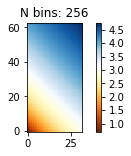

In [9]:
col1 = lib.getColorList("Blues",7)
col2 = lib.getColorList("YlOrBr_r",10)
colors =  col2[:] + col1[:]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)

lib.testColorMap(cmap)

Text(0,0.5,u'Run x Learning Rate')

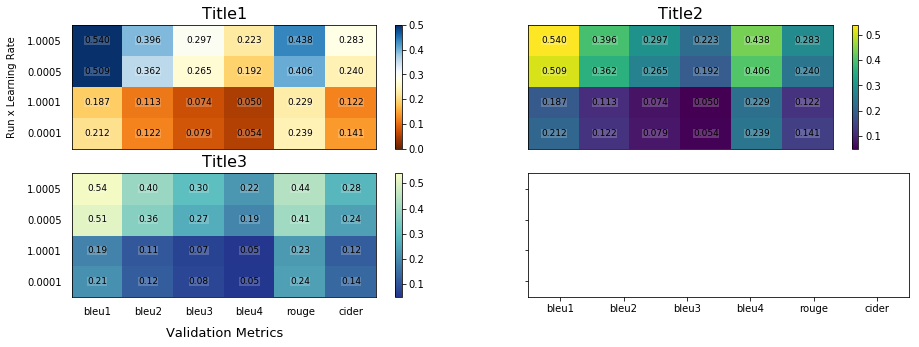

In [11]:
fig, ax = plt.subplots(2,2,sharex=True, sharey=True, figsize=(15,5))
#plt.subplots_adjust(hspace=0.5)
lib.plotHeatMap(df_test,"Title1",cmap,ax=ax[0,0],zrange=(0,.5))
lib.plotHeatMap(df_test,"Title2",ax=ax[0,1])
# Create custom colormap
colors= [u'#24368Eff',
         u'#5BBEC0ff',
         u'#F4FAC4ff']
plt.rcParams['figure.figsize'] = 5,2
ccmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotHeatMap(df_test,"Title3",ccmap,ax=ax[1,0],format=".2f")
ax[1,0].set_xlabel('Validation Metrics',size=13)
ax[0,0].set_ylabel('Run x Learning Rate')